<center> 
    <h1> Sequence to Sequence </h1>
</center>

<center> 
    <h2> Import library </h2>
</center>

In [27]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

<center> 
    <h2> Configuration </h2>
</center>

In [5]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = "./spa-eng/spa.txt"

<center>
    <h2> Prepare the data </h2>
</center>


In [7]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

In [8]:
lines

['Go.\tVe.',
 'Go.\tVete.',
 'Go.\tVaya.',
 'Go.\tVáyase.',
 'Hi.\tHola.',
 'Run!\t¡Corre!',
 'Run.\tCorred.',
 'Who?\t¿Quién?',
 'Fire!\t¡Fuego!',
 'Fire!\t¡Incendio!',
 'Fire!\t¡Disparad!',
 'Help!\t¡Ayuda!',
 'Help!\t¡Socorro! ¡Auxilio!',
 'Help!\t¡Auxilio!',
 'Jump!\t¡Salta!',
 'Jump.\tSalte.',
 'Stop!\t¡Parad!',
 'Stop!\t¡Para!',
 'Stop!\t¡Pare!',
 'Wait!\t¡Espera!',
 'Wait.\tEsperen.',
 'Go on.\tContinúa.',
 'Go on.\tContinúe.',
 'Hello!\tHola.',
 'I ran.\tCorrí.',
 'I ran.\tCorría.',
 'I try.\tLo intento.',
 'I won!\t¡He ganado!',
 'Oh no!\t¡Oh, no!',
 'Relax.\tTomátelo con soda.',
 'Smile.\tSonríe.',
 'Attack!\t¡Al ataque!',
 'Attack!\t¡Atacad!',
 'Get up.\tLevanta.',
 'Go now.\tVe ahora mismo.',
 'Got it!\t¡Lo tengo!',
 'Got it?\t¿Lo pillas?',
 'Got it?\t¿Entendiste?',
 'He ran.\tÉl corrió.',
 'Hop in.\tMétete adentro.',
 'Hug me.\tAbrázame.',
 'I fell.\tMe caí.',
 'I know.\tYo lo sé.',
 'I left.\tSalí.',
 'I lied.\tMentí.',
 'I lost.\tPerdí.',
 'I quit.\tDimito.',
 'I quit.\t

In [9]:

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [10]:


input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0


Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 86
Max sequence length for inputs: 17
Max sequence length for outputs: 42


<center> 
    <h2> Build the model </h2>
</center>


In [21]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)


<center> 
    <h2> Train the model </h2>
</center>

In [28]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)

Epoch 1/100
125/125 [==============================] - 5s 24ms/step - loss: 0.1568 - accuracy: 0.9529 - val_loss: 0.8784 - val_accuracy: 0.8056
Epoch 2/100
125/125 [==============================] - 2s 16ms/step - loss: 0.1498 - accuracy: 0.9553 - val_loss: 0.8797 - val_accuracy: 0.8067
Epoch 3/100
125/125 [==============================] - 2s 16ms/step - loss: 0.1479 - accuracy: 0.9556 - val_loss: 0.8901 - val_accuracy: 0.8053
Epoch 4/100
125/125 [==============================] - 2s 17ms/step - loss: 0.1450 - accuracy: 0.9568 - val_loss: 0.8979 - val_accuracy: 0.8054
Epoch 5/100
125/125 [==============================] - 2s 16ms/step - loss: 0.1430 - accuracy: 0.9571 - val_loss: 0.9008 - val_accuracy: 0.8046
Epoch 6/100
125/125 [==============================] - 2s 16ms/step - loss: 0.1399 - accuracy: 0.9582 - val_loss: 0.9062 - val_accuracy: 0.8044
Epoch 7/100
125/125 [==============================] - 2s 16ms/step - loss: 0.1371 - accuracy: 0.9592 - val_loss: 0.9105 - val_accuracy:

In [29]:
# Save model
model.save("Seq2Seq")

INFO:tensorflow:Assets written to: Seq2Seq/assets


INFO:tensorflow:Assets written to: Seq2Seq/assets


<center> 
    <h3> History model </h3>
</center>

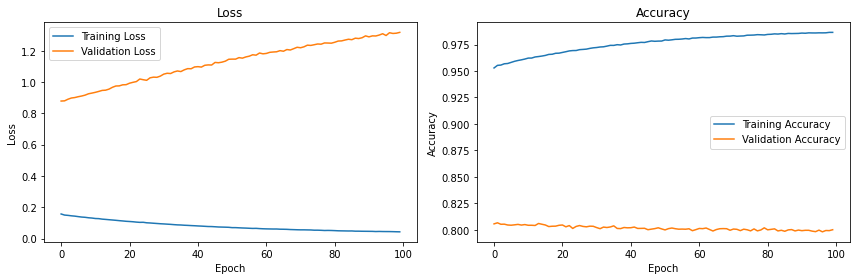

In [30]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
 
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

<center> 
    <h2> Run inderence </h2>
</center>

In [31]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("Seq2Seq")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence


In [32]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)


1/1 [==============================] - 0s 23ms/step
-
Input sentence: Go.
Decoded sentence: Vaya.

1/1 [==============================] - 0s 19ms/step
-
Input sentence: Go.
Decoded sentence: Vaya.

1/1 [==============================] - 0s 18ms/step
-
Input sentence: Go.
Decoded sentence: Vaya.

1/1 [==============================] - 0s 17ms/step
-
Input sentence: Go.
Decoded sentence: Vaya.

1/1 [==============================] - 0s 17ms/step
-
Input sentence: Hi.
Decoded sentence: Hola.

1/1 [==============================] - 0s 16ms/step
-
Input sentence: Run!
Decoded sentence: ¡Corre!

1/1 [==============================] - 0s 21ms/step
-
Input sentence: Run.
Decoded sentence: Corred.

1/1 [==============================] - 0s 17ms/step
-
Input sentence: Who?
Decoded sentence: ¿Quién?

1/1 [==============================] - 0s 20ms/step
-
Input sentence: Fire!
Decoded sentence: ¡Incendio!

1/1 [==============================] - 0s 17ms/step
-
Input sentence: Fire!
Decoded sentence: